# Train AE with data generated on MullerBrown potential 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.ZPotential import ZPotential
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [4]:
pot = ZPotential()
import torch 
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
beta = 1.5
dt = 0.1
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**7

In [ ]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [ ]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [5]:
trajs = np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)
np.savetxt('dataset_ZP.txt', trajs)

NameError: name 'traj_dict1' is not defined

In [6]:
trajs = np.loadtxt('dataset_ZP.txt')
trajs = trajs[np.random.choice(len(trajs), size=2 * 10**6)]

/home/tpigeon/miniconda3/envs/env_ae/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


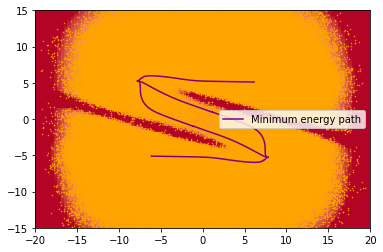

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.plot(pot.minimum_energy_paths[2][:, 0], pot.minimum_energy_paths[2][:, 1], color='purple')
ax.plot(pot.minimum_energy_paths[3][:, 0], pot.minimum_energy_paths[3][:, 1], color='purple')
ax.scatter(trajs[:, 0], trajs[:, 1], marker=".", color="orange", s=1)
ax.legend()

In [7]:
dataset = {"boltz_points": trajs}

In [8]:
dataset.keys()

dict_keys(['boltz_points'])

Import AE model 

In [11]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.train_aes import TainAEOneDecoder

Create autoencoder object

In [79]:
del(ae)
del(ae_training)

In [80]:
seed = 50   ## Seed 5, 25 works fine without physiscal penalization, pen make the result bad
## seed 50 does dot work fine without them  
set_all_seeds(seed)
ae = DeepAutoEncoder([2, 5, 5, 1], [1, 20, 20, 2], 0)

Created training object

In [81]:
ae_training = TainAEOneDecoder(ae, pot, dataset.copy(), standardize=False, zca_whiten=False)

Set the training size and do the train-test split

In [82]:
ae_training.train_test_split(train_size=2 * 10**4)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)

Set the optimizer 

In [83]:
ae_training.set_optimizer('Adam', 0.005)

Set the loss function parameters 

In [84]:
loss_params = {}
loss_params["mse_boltz_weight"] = 1.0 * 10**(0)
loss_params["squared_grad_boltz_weight"] = 0. * 10**(-2)
loss_params["var_enc_weight"] = 0. * 10**(4)
loss_params["n_wait"] = 50
ae_training.set_loss_weight(loss_params)

mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0
pen_points_mse_weight value not provided, set to default value of:  0.0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [85]:
batch_size = 1000
max_epochs = 10000

Train 

In [86]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 493 epochs.



Plot the evolution of the loss stating from the 100th epoch 

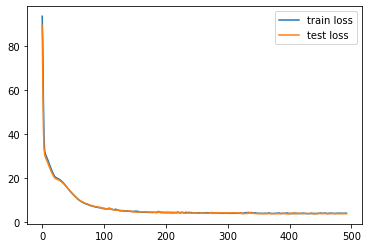

In [87]:
plt.figure()
plt.plot(loss_dict["train_loss"][:], label='train loss')
plt.plot(loss_dict["test_loss"][:], label='test loss')
plt.legend()

Plot the conditionnal averages on the potential heat map 

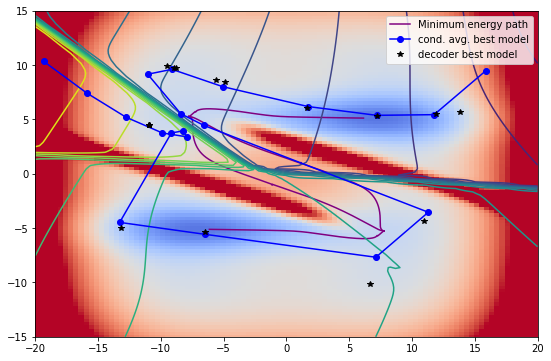

In [88]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.plot(pot.minimum_energy_paths[2][:, 0], pot.minimum_energy_paths[2][:, 1], color='purple')
ax.plot(pot.minimum_energy_paths[3][:, 0], pot.minimum_energy_paths[3][:, 1], color='purple')
#ax.plot(Esp_X_given_z[:, 0], Esp_X_given_z[:, 1], '-o', color='blue', label='cond. avg. best model')
#ax.plot(f_dec_z[:, 0], f_dec_z[:, 1], '*', color='black', label='decoder best model')
ae_training.plot_encoder_iso_levels(ax, 20)
ae_training.plot_conditional_averages(ax, 20)

ax.legend()

Plot convergence of the principal curve 

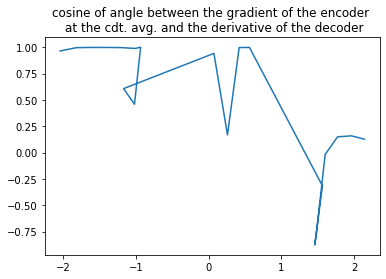

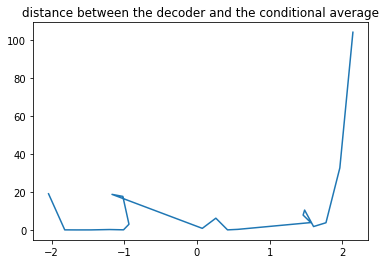

In [89]:
ae_training.plot_principal_curve_convergence(20)

In [90]:
ae_training.print_test_loss()

Test loss:  tensor(4.0749, grad_fn=<AddBackward0>)
Test MSE Boltzmann:  tensor(4.0749, grad_fn=<MeanBackward0>)
Test squarred grad encoder:  tensor(0.0510, grad_fn=<MeanBackward0>)
